In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.linalg import qr
import pickle
from random import randint

BAD = ['VT', 'VFb', 'VFt'] # KIS,S

In [2]:
# DEFINE WHERE ALL OF THE FILES ARE - UNLABED EXCEPT BY NAME
dir_path = r'C:\Users\jodge\Documents\School\Summer24\tinyml_contest_data_training'
directory_files = os.listdir(dir_path)
num_files = len(directory_files)

# GET INFO TO ACCESS THOSE FILES
root_project_path = r'C:\Users\jodge\Documents\School\Summer24\tinymlcontest2022_demo_example'
label_filename = r'label_list.csv' # in demo path - Maps abbrevations to full medical names of conditions. small file.
indices_path = os.path.join(root_project_path, 'data_indices')

test_filename = r'test_indice.csv'  # in label path
train_filename = r'train_indice.csv' # in label path

test_path = os.path.join(indices_path, test_filename)
train_path = os.path.join(indices_path, train_filename)

df_test_indices = pd.read_csv(test_path, sep=",", header=0)
df_train_indices = pd.read_csv(train_path, sep=",", header=0)

#####

label_path = os.path.join(root_project_path, label_filename)
df_labels = pd.read_csv(label_path, sep=',', header=0)

label_dict = {k : v for k,v in df_labels.values} # Afs : Atrial Fibrillation, etc.

In [3]:
def saveObj(obj, filename):
    print(f"saving to {filename}")
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

def readObj(filename):
    print(f"reading from {filename}")
    with open(filename, 'rb') as file:
       return pickle.load(file)

def readFile(filename):
    return pd.read_csv(os.path.join(dir_path, filename), header=None).to_numpy().flatten()

def getRandomFile(category = None): #includes test and train, just a dummy testing helper method
    if not category:
        random_idx = randint(0,len(df_train_indices))
        filename = df_train_indices.Filename[random_idx]
        file_path = os.path.join(dir_path, filename)
        reader = pd.read_csv(file_path, sep = " ", header = None)
        return reader.to_numpy().flatten(), filename
    else:
        random_idx = randint(0,len(df_train_indices))
        filename = df_train_indices.Filename[random_idx]
        temp = filename.split('-')
        cat = temp[1] # gets the label category
        while (cat != category):
            random_idx = randint(0,len(df_train_indices))
            filename = df_train_indices.Filename[random_idx]
            temp = filename.split('-')
            cat = temp[1]
        file_path = os.path.join(dir_path, filename)
        reader = pd.read_csv(file_path, sep = " ", header = None)
        return reader.to_numpy().flatten(), filename
    
def averageSignals(signals):
    arrays = [readFile(file) for file in signals]
    stacked = np.stack(arrays) 
    return np.mean(stacked, axis=0)

def getGoodBadMatrices():
    pkl_name = r"goodBadMats.pkl"
    pkl_loc = os.path.join("data", pkl_name)
    
    if os.path.exists(pkl_loc):
        holder = readObj(pkl_loc)
        return holder
        
    else:
        print("creating", pkl_loc)
        holder = {}
        holder['GOOD'] = []
        holder['BAD'] = [] 
        for filename in df_train_indices.Filename:
            temp = filename.split('-')
            cat = temp[1] # gets the label category
            if cat in BAD:
                holder['BAD'].append(filename)
            else:
                holder['GOOD'].append(filename)
        for label, filenames in holder.items():
            arrays = [readFile(file) for file in filenames]
            holder[label] = np.stack(arrays, axis = 1)
        saveObj(holder, pkl_loc)
        return holder

def getCategoryMatrices():
    pkl_name = r"catMats.pkl"
    pkl_loc = os.path.join("data", pkl_name)
    
    if os.path.exists(pkl_loc):
        holder = readObj(pkl_loc)
        return holder
        
    else:
        print("creating", pkl_loc)
        holder = {}
        for label in label_dict.keys():
            holder[label] = [] # initialize holder 
        for filename in df_train_indices.Filename:
            temp = filename.split('-')
            cat = temp[1] # gets the label category
            holder[cat].append(filename)
        for label, filenames in holder.items():
            arrays = [readFile(file) for file in filenames]
            holder[label] = np.stack(arrays, axis = 1)
        saveObj(holder, pkl_loc)
        return holder
        
def getAverageGoodBadSignals():
    pkl_name = r"avgGoodBadSigs.pkl"
    pkl_loc = os.path.join("data", pkl_name)

    if os.path.exists(pkl_loc):
        signals = readObj(pkl_loc)
        return signals
    else:
        print("creating", pkl_loc)
        holder = {}
        signals = {}
        holder['GOOD'] = []
        holder['BAD'] = []
        for filename in df_train_indices.Filename:
            temp = filename.split('-')
            cat = temp[1] # gets the label category
            if cat in BAD:
                holder['BAD'].append(filename)
            else:
                holder['GOOD'].append(filename)
            
        for label, file_list in holder.items():
            signals[label] = averageSignals(file_list)
        saveObj(signals, pkl_loc)
        return signals
def getAveragedCategorySignals(): #only training data
    pkl_name = r"avgCatSigs.pkl"
    pkl_loc = os.path.join("data", pkl_name)

    if os.path.exists(pkl_loc):
        signals = readObj(pkl_loc)
        return signals
    else:
        print("creating", pkl_loc)
        holder = {}
        signals = {}
        for label in label_dict.keys():
            holder[label] = [] # initialize holder 
        for filename in df_train_indices.Filename:
            temp = filename.split('-')
            cat = temp[1] # gets the label category
            holder[cat].append(filename)
            
        for label, file_list in holder.items():
            signals[label] = averageSignals(file_list)
        saveObj(signals, pkl_loc)
        return signals

def getAverageSignal():
    return averageSignals(df_train_indices.Filename)

def getFullTrainSignalMatrix(): #all files with each as a column
    pkl_name = r"fullTrainMat.pkl"
    pkl_loc = os.path.join("data", pkl_name)

    if os.path.exists(pkl_loc):
        answer = readObj(pkl_loc)
        return answer
    else:
        print("creating", pkl_loc)
        arrays = [readFile(file) for file in df_train_indices.Filename]
        answer = np.stack(arrays, axis=1)
        saveObj(answer, pkl_loc)
        return answer
    
def plotSignal(x, title, style = 'b-', sampleLength = 5):
    n = len(x)
    print(n)
    t = np.linspace(0, sampleLength, n)
    plt.plot(t, x, style)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

def plotPairSignals(x1, x2, title1, title2, style = 'b-'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    n = len(x1)
    t = np.linspace(0, 5, n)
    ax1.plot(t, x1, style)
    ax1.set_title(title1)
    ax2.plot(t, x2, style)
    ax2.set_title(title2)
    plt.tight_layout()
    plt.show()

def svd(x = getFullTrainSignalMatrix()):
    U, S, VT = np.linalg.svd(x, full_matrices=False) #full_matrices=False
    S = np.diag(S)
    return (U, S, VT)
    
def reconstruct(U, S, VT, r = 500):
    return U[:,:r] @ S[0:r,:r] @ VT[:r,:]

def plotCumSum(S):
    plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
    plt.title('Singular Values: Cumulative Sum')
    plt.show()

def ranksForEnergyCapture(S, energy_wanted = 0.90):
    captured = np.cumsum(np.diag(S))/np.sum(np.diag(S))
    index = np.searchsorted(captured, energy_wanted)
    return index + 1

reading from data\fullTrainMat.pkl


In [4]:
fullTrainSignalMatrix = getFullTrainSignalMatrix()
catSigs = getAveragedCategorySignals()
catMats = getCategoryMatrices()

reading from data\fullTrainMat.pkl
reading from data\avgCatSigs.pkl
reading from data\catMats.pkl


In [17]:
class SVD:
    def __init__(self, U, S, VT):
        self.U = U
        self.S = S
        self.VT = VT

class ProblemSetup:
  def __init__(self, r, p, fullSVD, truncSVD, Q, R, pivots, C):
      self.r = r
      self.p = p
      self.fullSVD = fullSVD
      self.truncSVD = truncSVD
      self.Q = Q
      self.R = R
      self.pivots = pivots
      self.C = C

def processData(trainingData, label, r = 400, p = 500): # r and p chosen kinda randomly for now. r = ranks desired, p = num sensors,
    U, S, VT = svd(trainingData)
    full_SVD = SVD(U, S, VT)
    
    #reshape SVD according to r
    U_hat, S_hat, VT_hat = U[:,:r], S[:r,:r], VT[:r,:]
    trunc_SVD = SVD(U_hat, S_hat, VT_hat)
    
    Q, R, pivots = None, None, None
    if (p == r):
        Q, R, pivots = qr(U_hat, pivoting = True) # or maybe just U
    elif (p > r): # oversampled
        Q, R, pivots = qr(U_hat @ U_hat.T, pivoting = True) # or maybe just U
    else:
        for _ in range(100):
            print("ERROR p < r")
            
    pivots = pivots[:p]
    print(np.array_equal(trainingData, fullTrainSignalMatrix))
    # Create C matrix
    C = np.zeros((p, fullTrainSignalMatrix.shape[0]))
    print(C.shape, pivots.shape)
    C[np.arange(p), pivots] = 1

    problemSetup = ProblemSetup(r, p, full_SVD, trunc_SVD, Q, R, pivots, C)
    filename = os.path.join("data", label + ".pkl")
    saveObj(problemSetup, filename)
    
    return problemSetup

def measureAndReconstruct(problemSetup, signal):
    # Measure a signal
    C, U_hat, p, r, pivots =  problemSetup.C, problemSetup.truncSVD.U, problemSetup.p, problemSetup.r, problemSetup.pivots
    y = C @ signal
    
    # Solve for coefficients #CLAUDE assisted here down
    U_k_reduced = U_hat[:, :p][pivots, :]
    
    if p == r:
        a = np.linalg.lstsq(U_k_reduced, y, rcond=None)[0]
    else:
        a = np.linalg.pinv(C @ U_hat) @ y

    x_reconstructed = U_hat @ a
    mseFinal = np.mean((signal - x_reconstructed) ** 2)
    return mseFinal, x_reconstructed

FUCK
False
(107, 1250) (107,)
saving to data\AFb.pkl


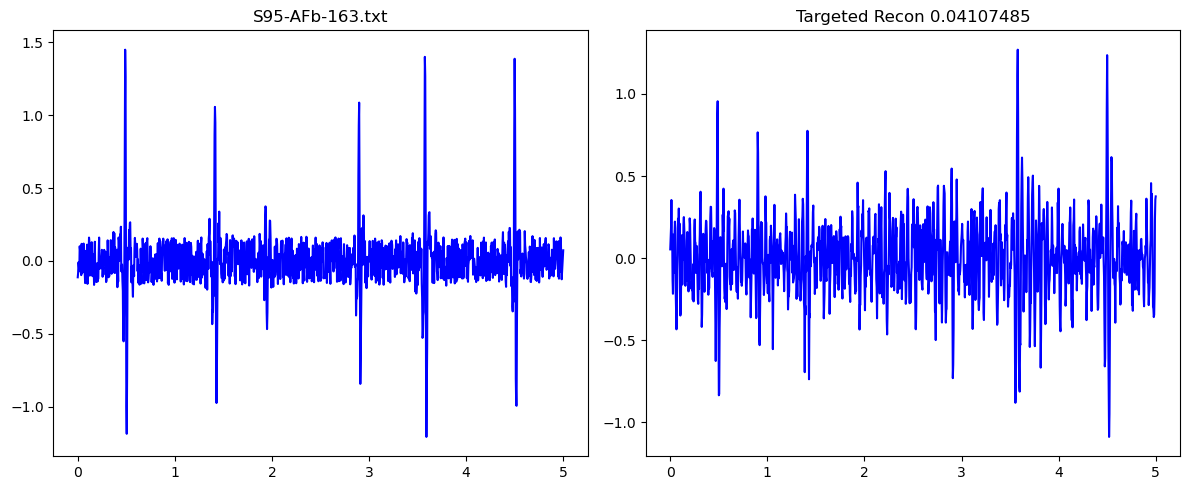

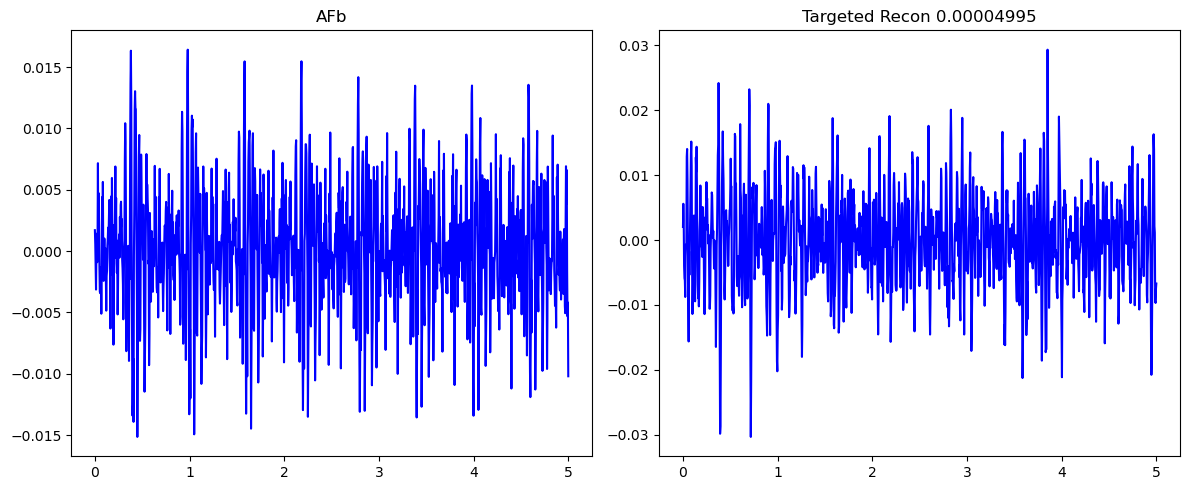

FUCK
False
(107, 1250) (107,)
saving to data\AFt.pkl


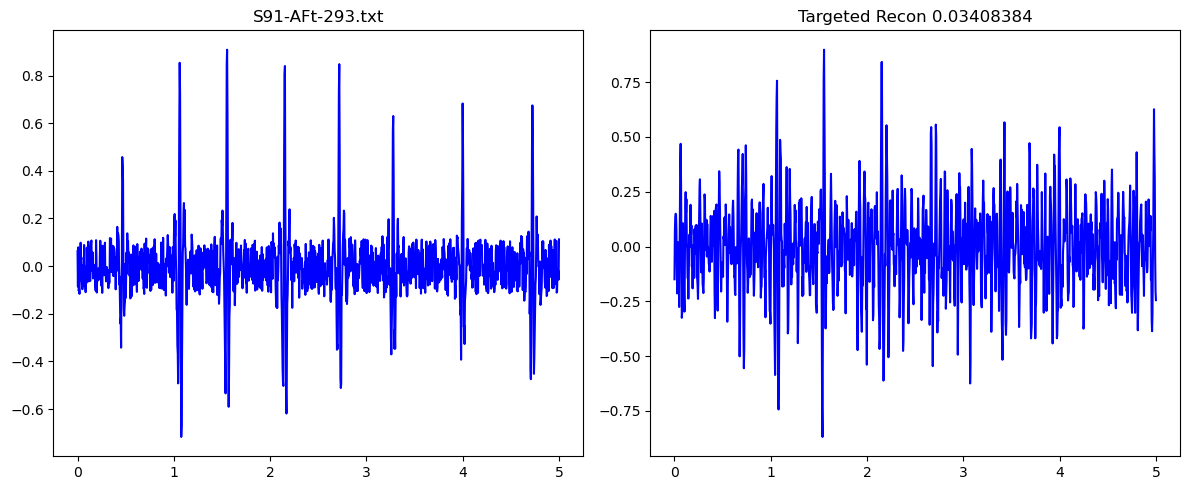

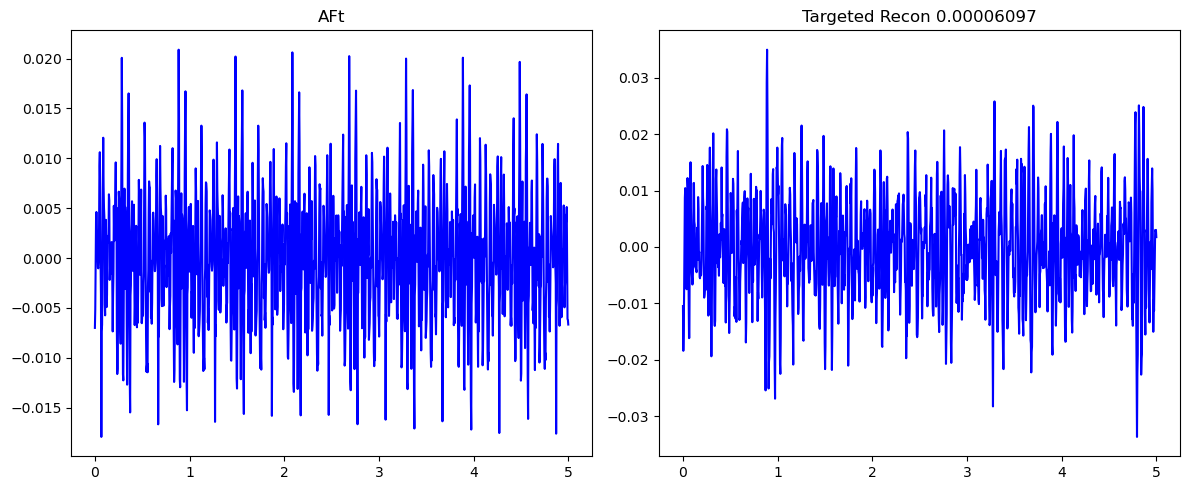

FUCK
False
(107, 1250) (107,)
saving to data\SR.pkl


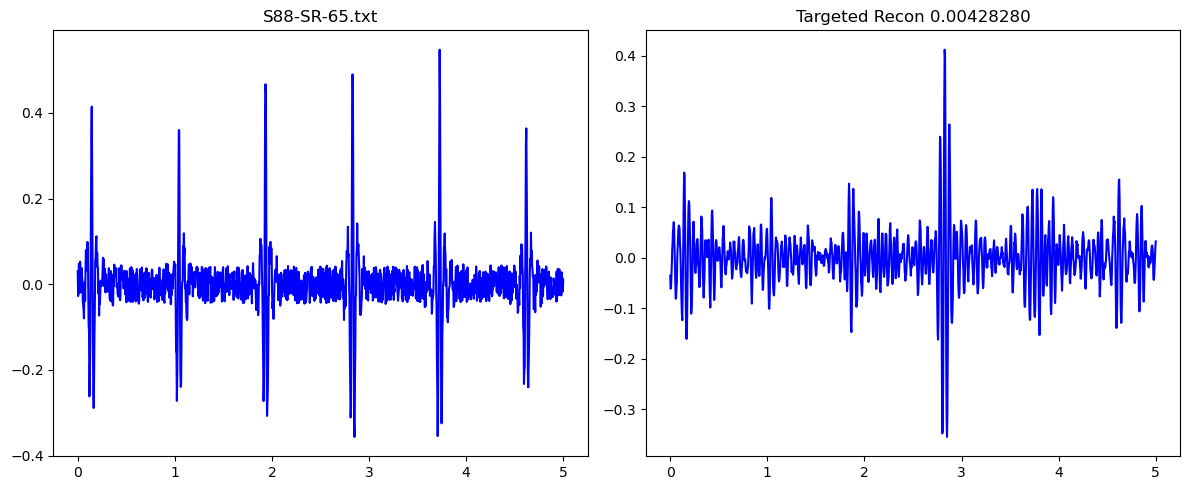

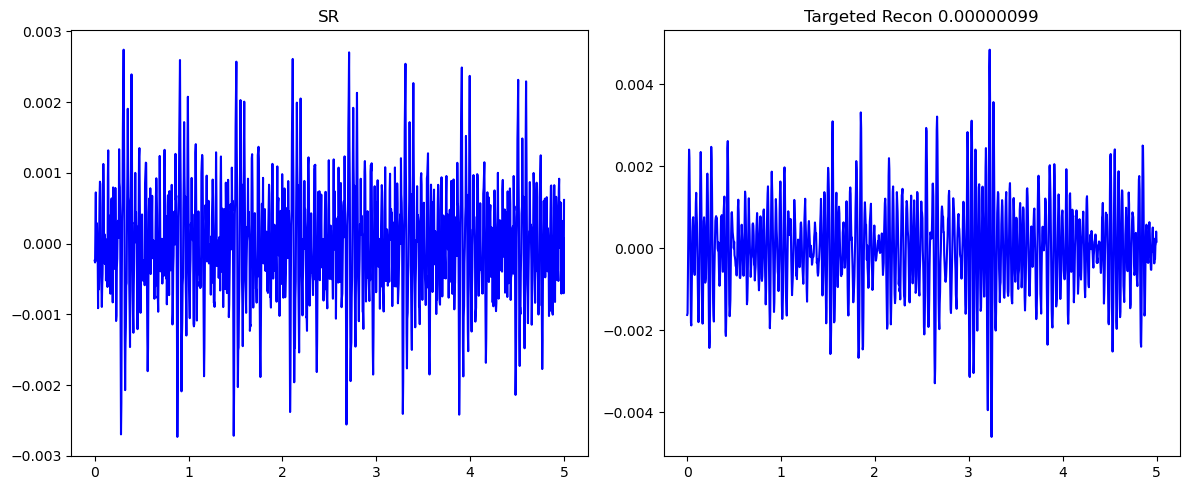

FUCK
False
(107, 1250) (107,)
saving to data\SVT.pkl


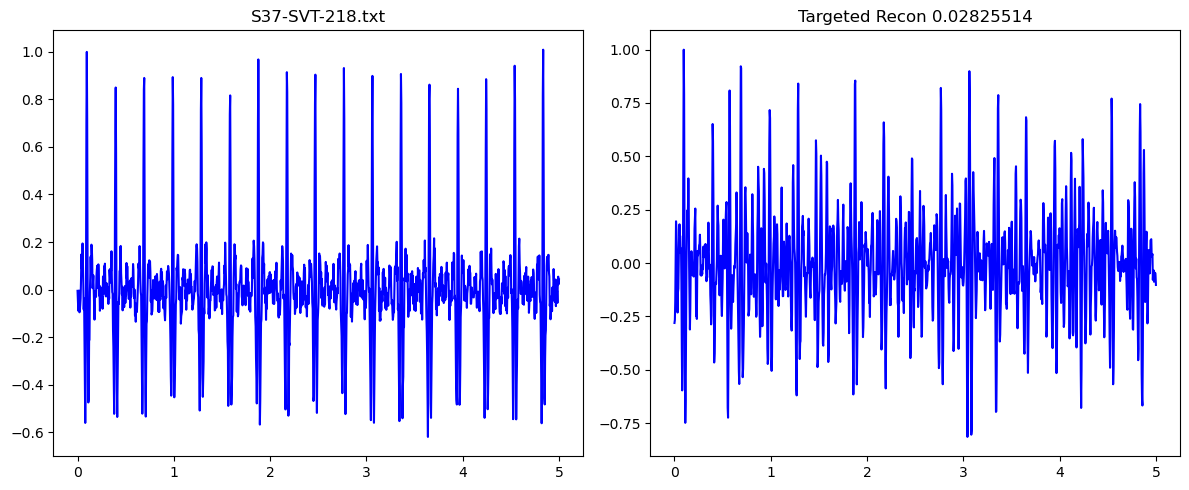

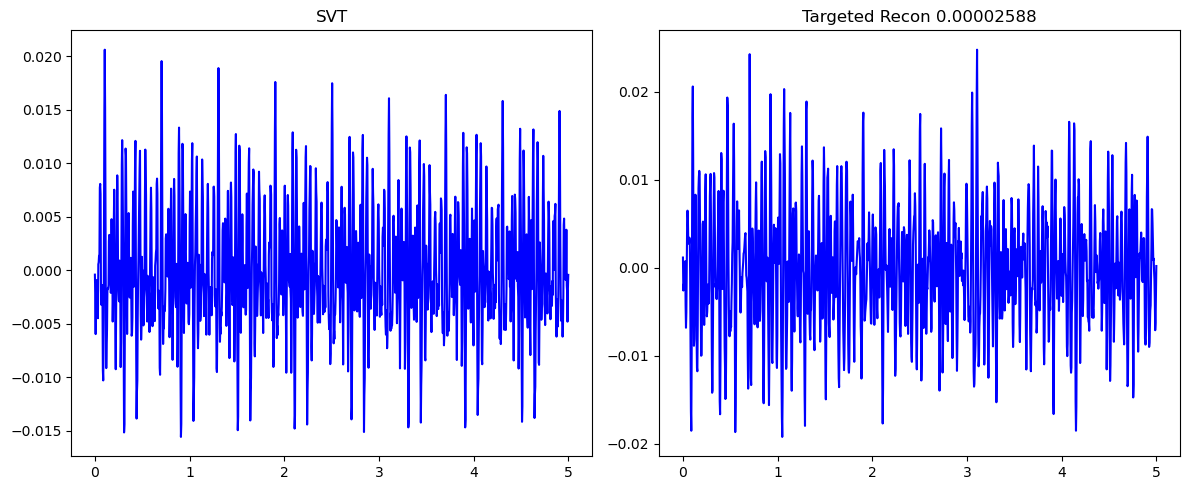

FUCK
False
(107, 1250) (107,)
saving to data\VFb.pkl


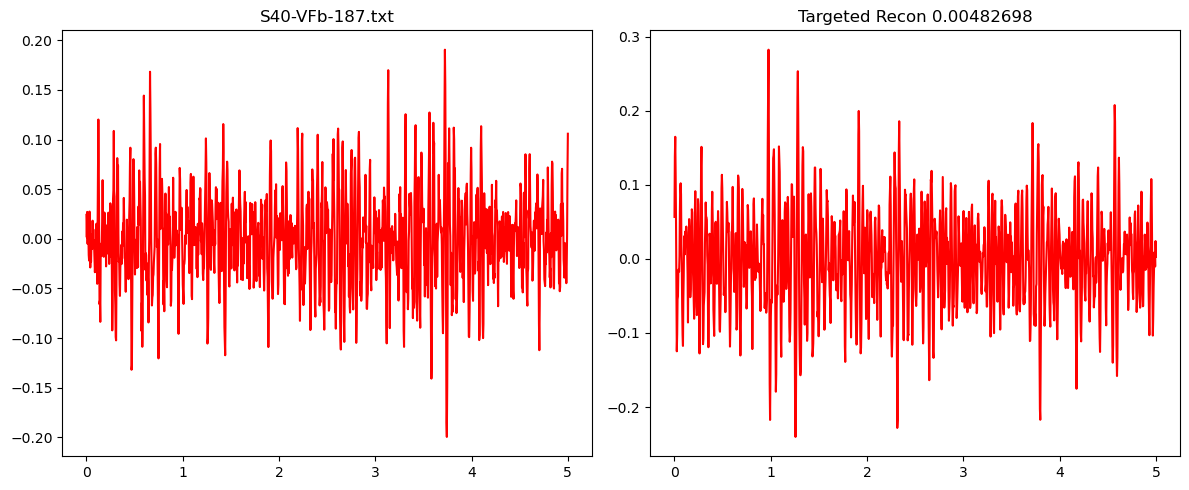

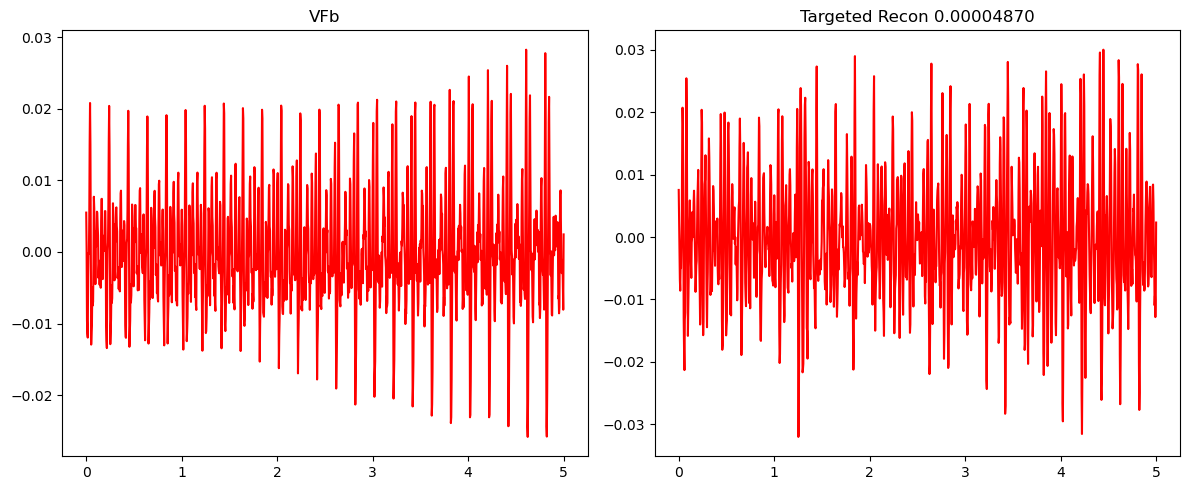

FUCK
False
(107, 1250) (107,)
saving to data\VFt.pkl


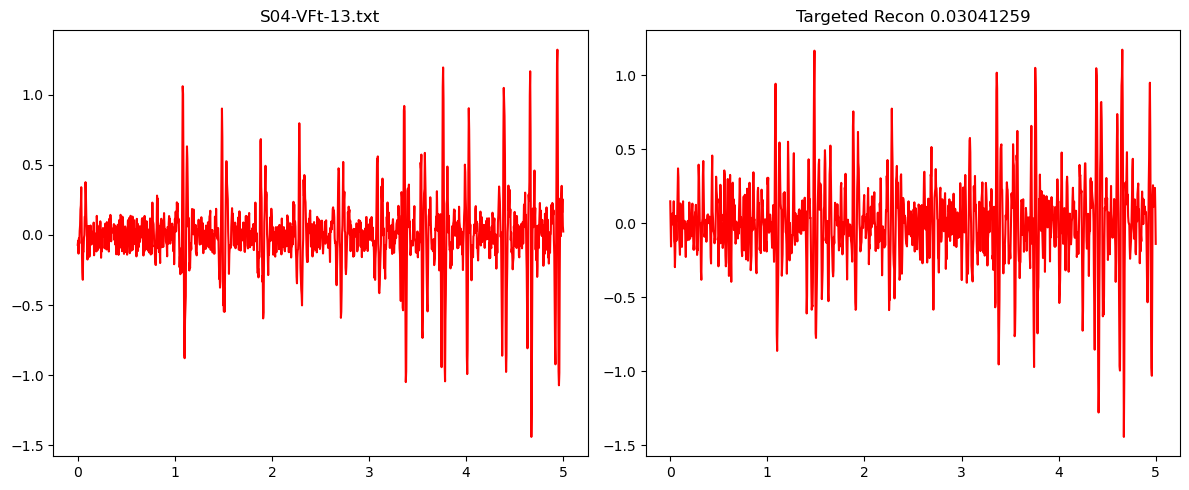

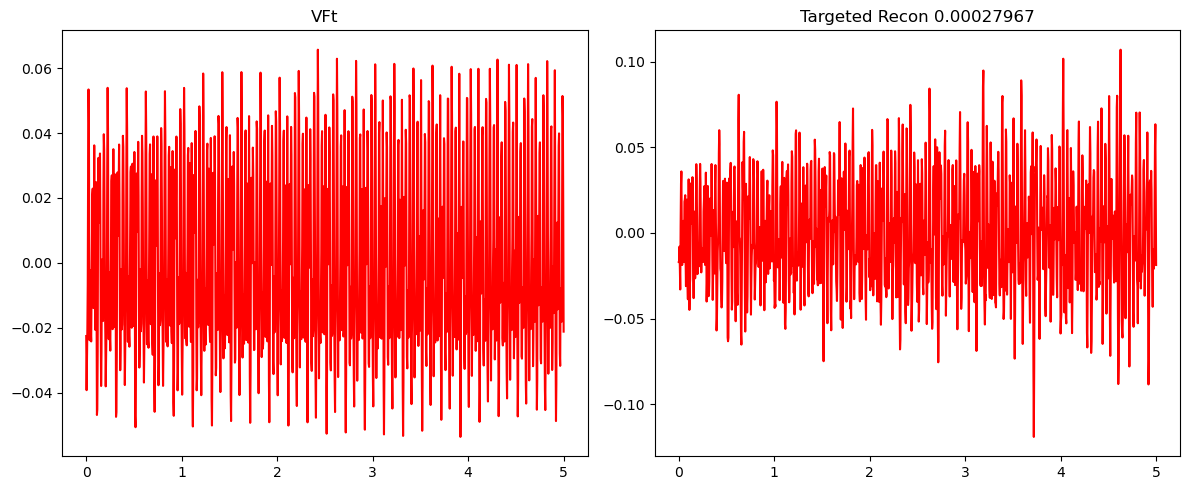

FUCK
False
(107, 1250) (107,)
saving to data\VPD.pkl


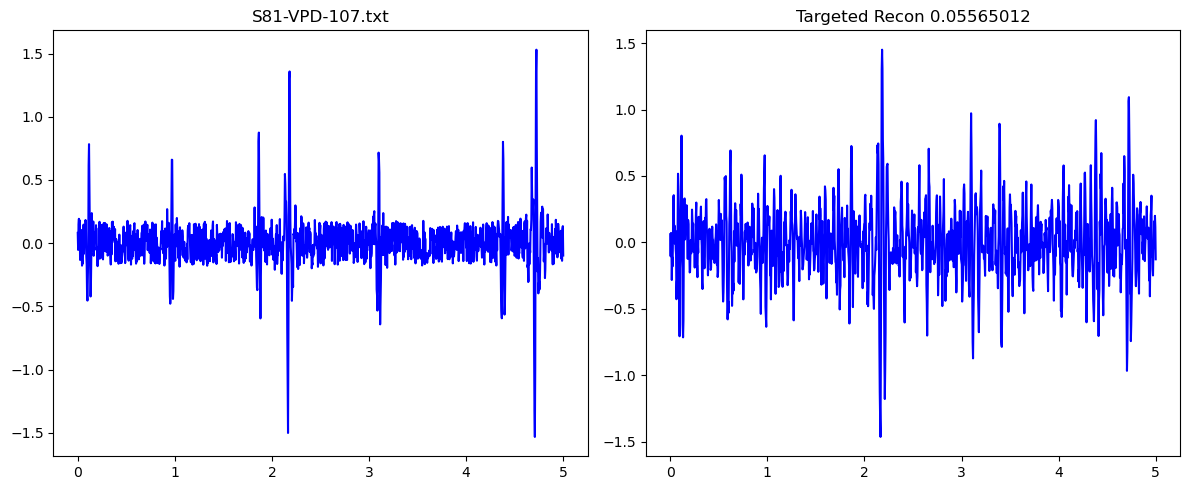

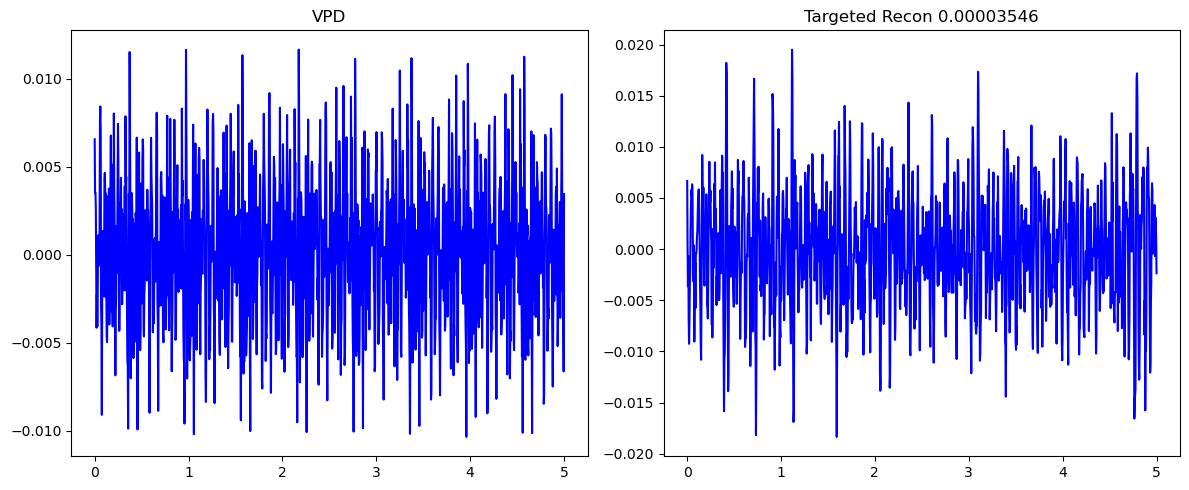

FUCK
False
(107, 1250) (107,)
saving to data\VT.pkl


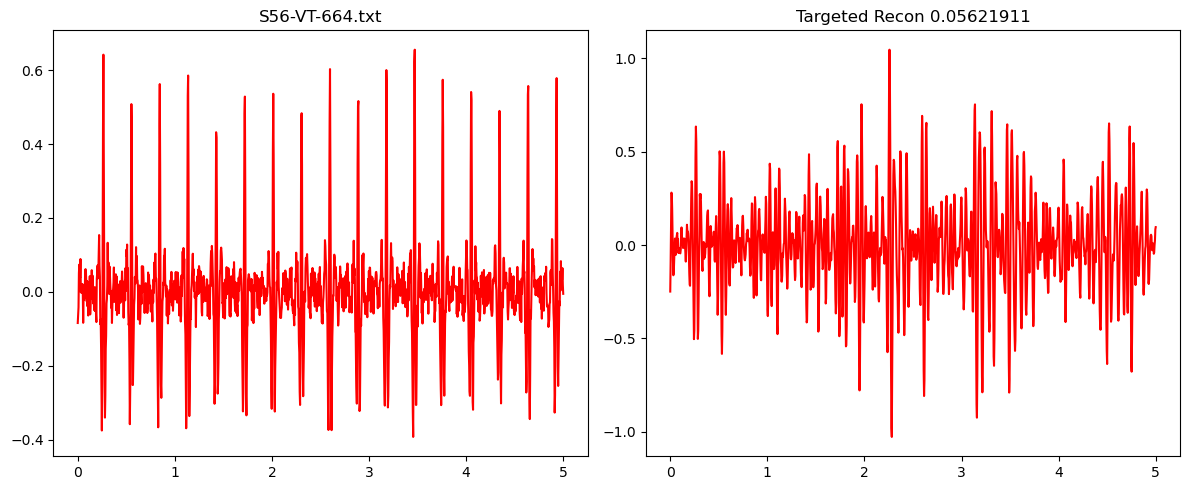

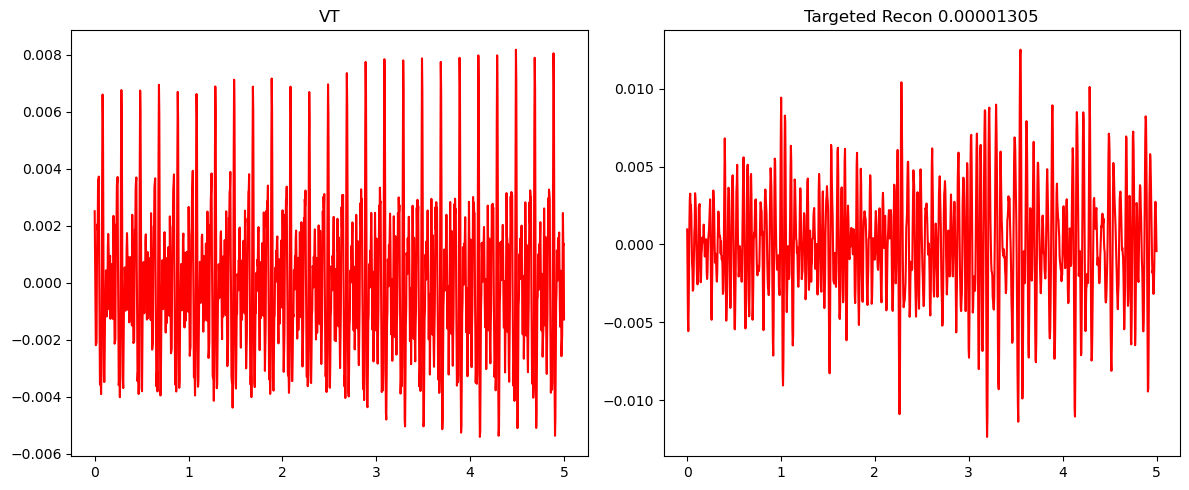

FUCK
True
(107, 1250) (107,)
saving to data\full.pkl


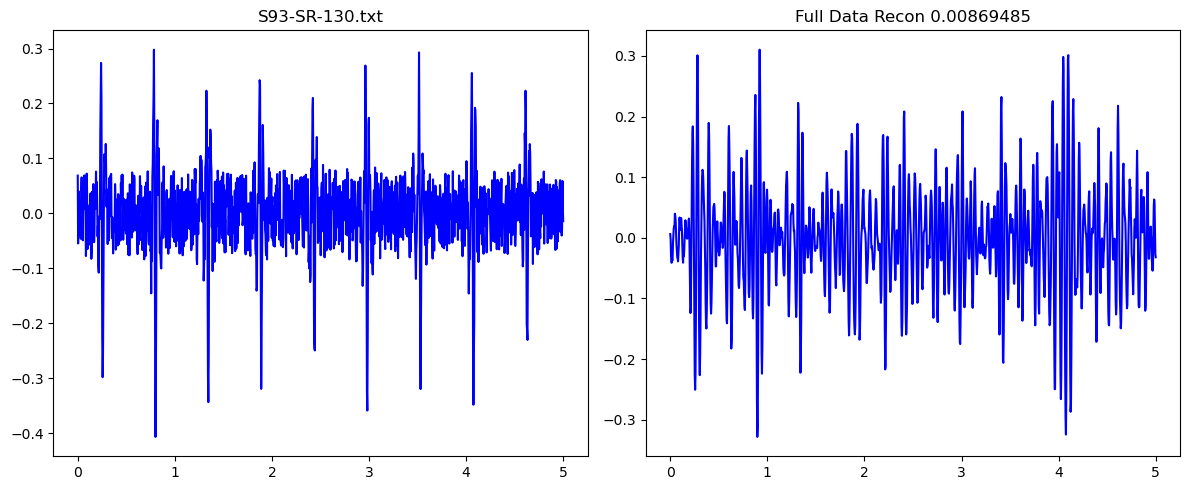

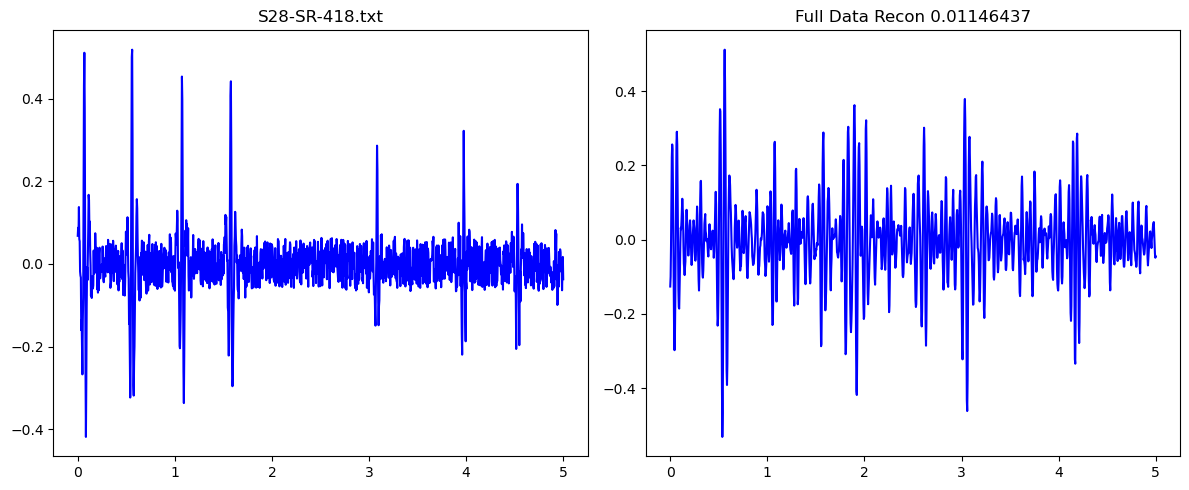

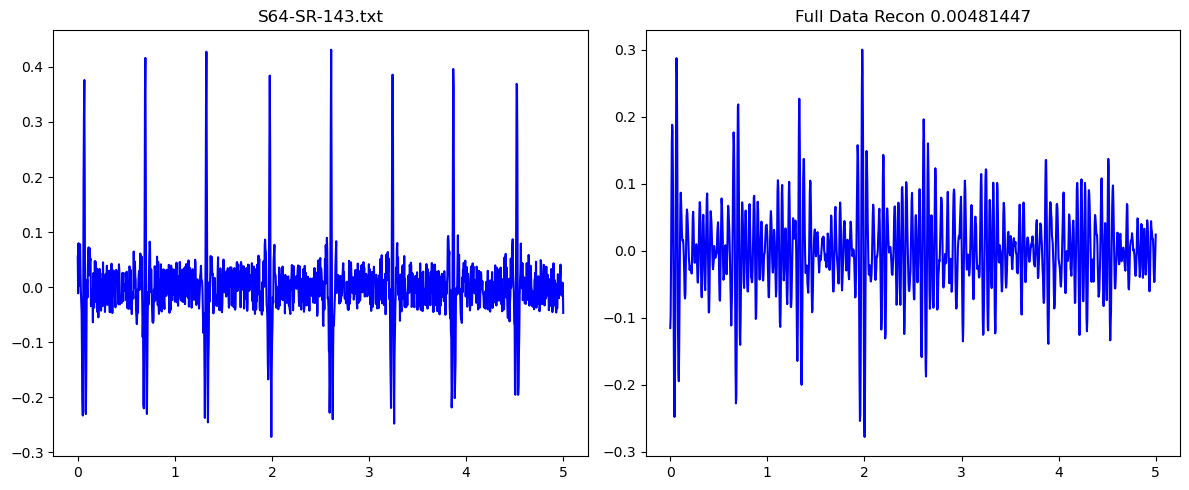

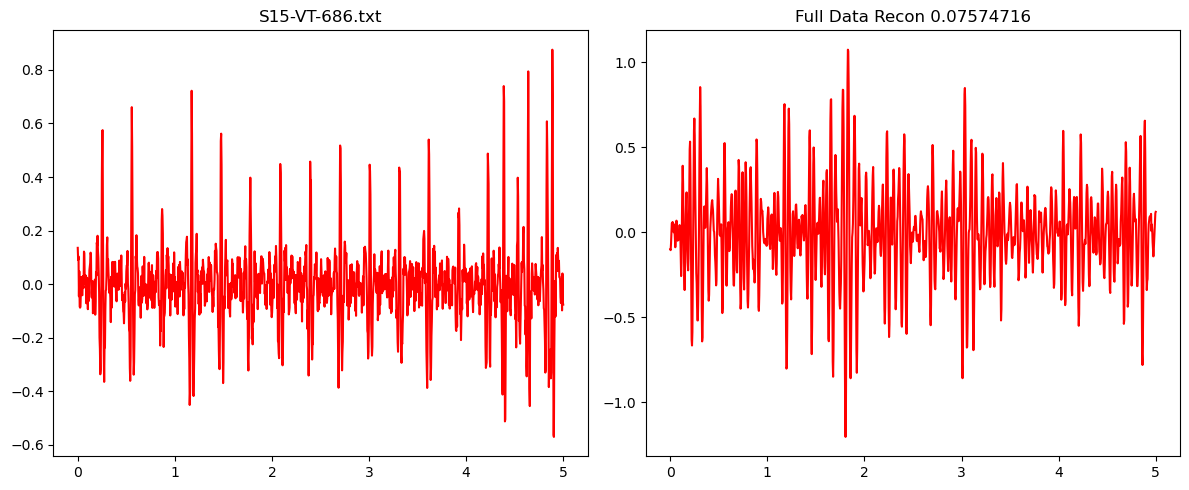

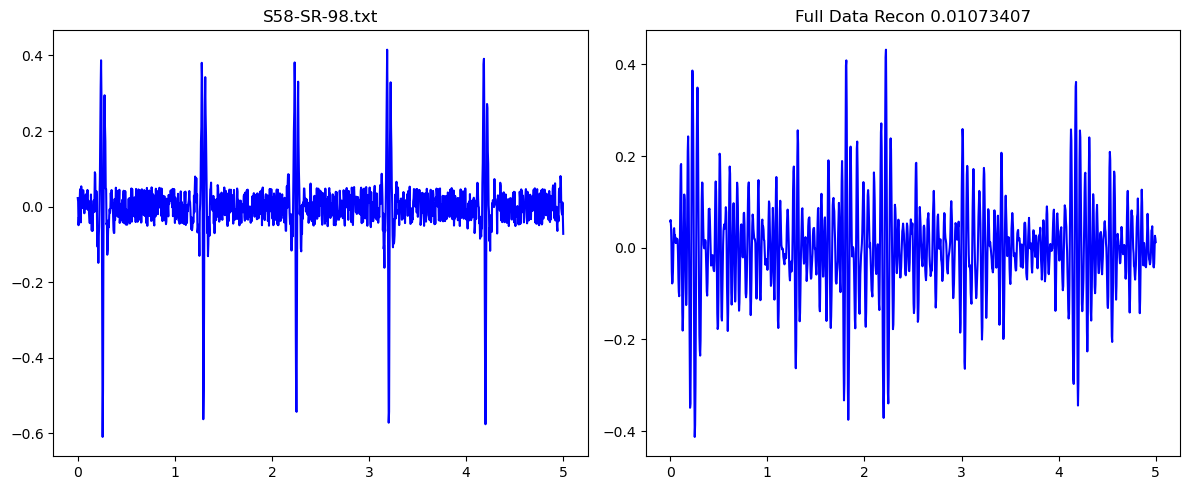

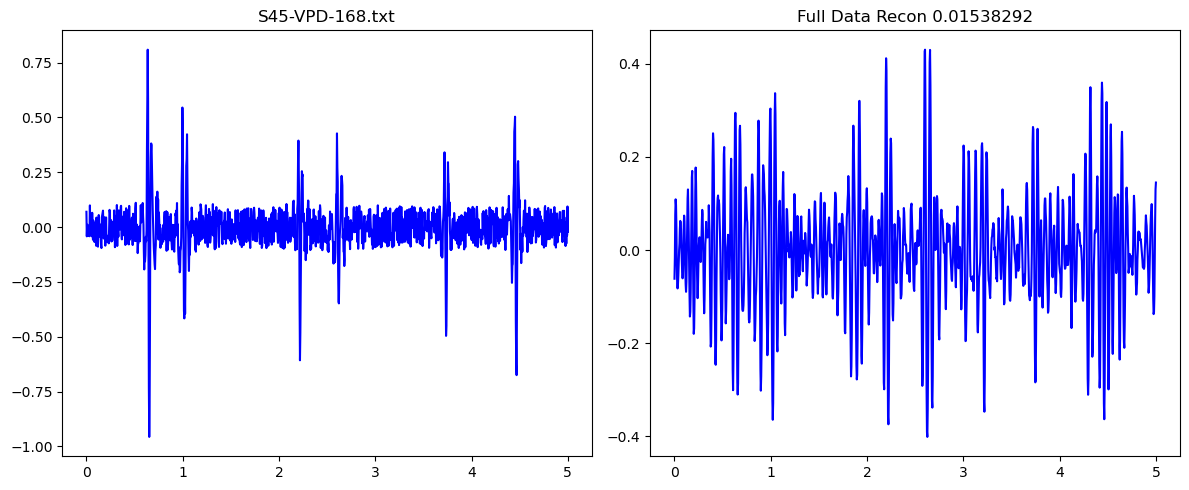

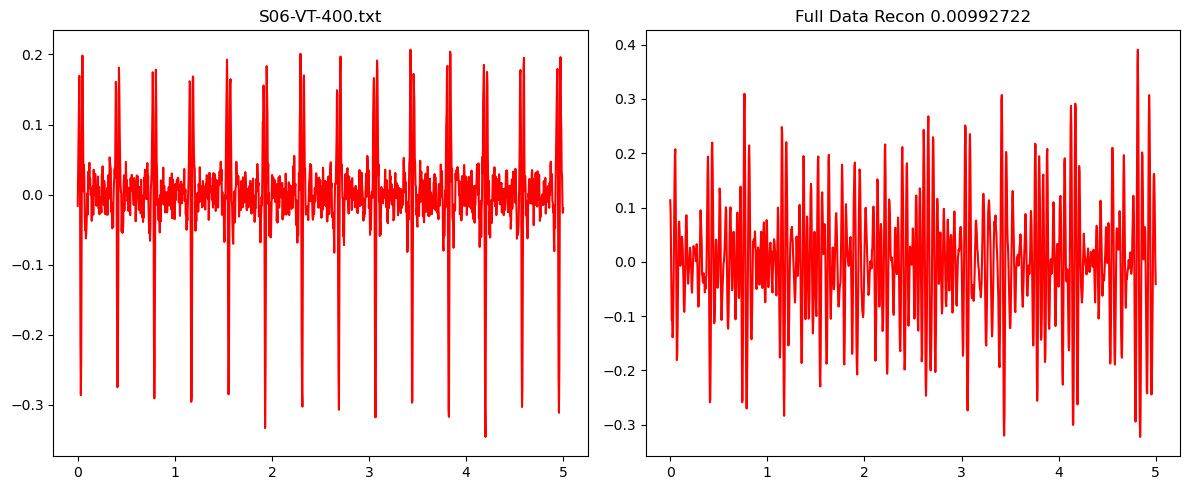

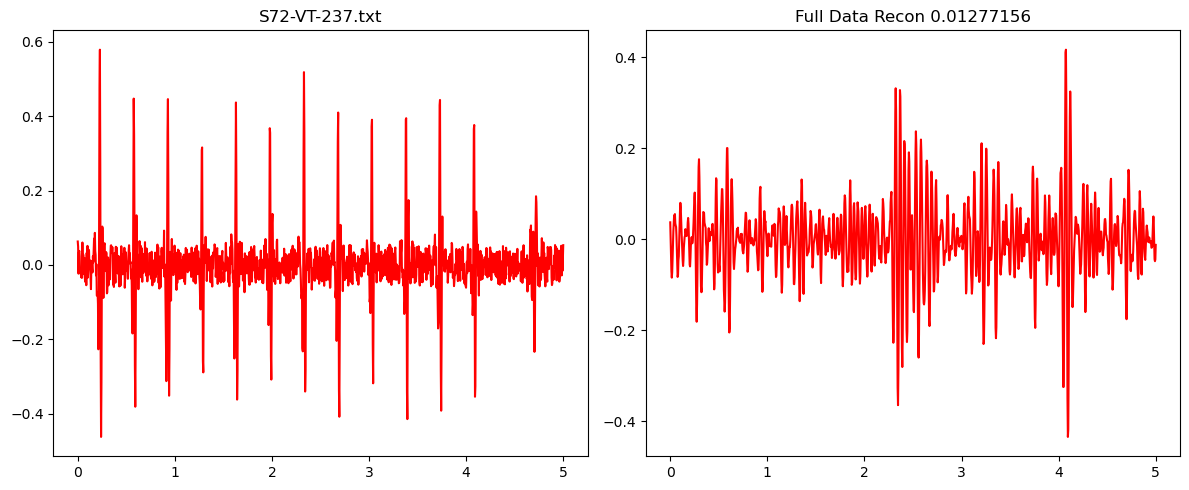

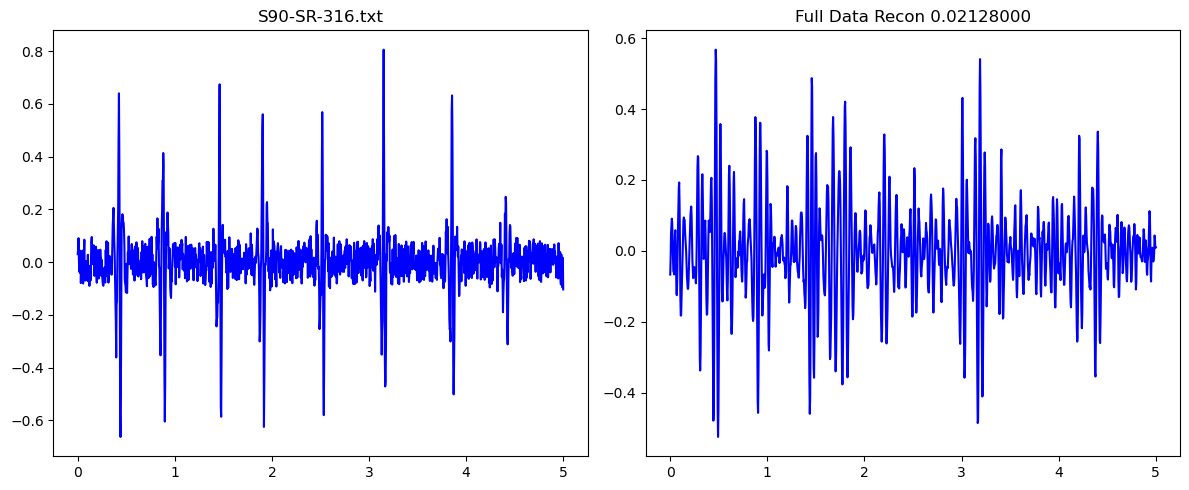

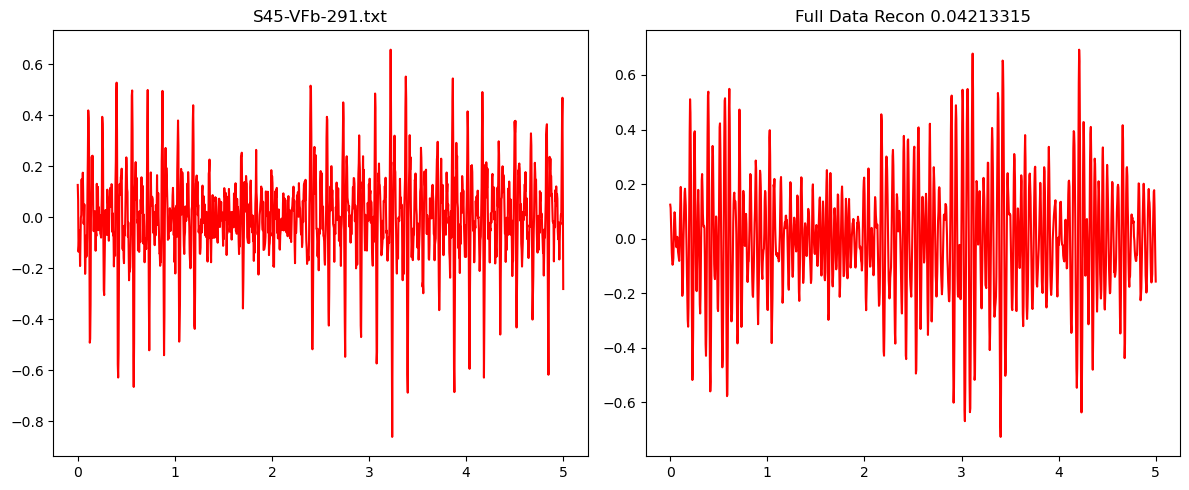

In [20]:
r = 106
p = r + 1

### SHOW HOW SPECIALIZED SOLUTION WORKS FOR A RANDOM SIGNAL OF ITS CATEGORY
for label, dataMatrix in catMats.items():
    problemSetup = processData(dataMatrix, label, r, p)
    randSig, randSigName = getRandomFile(label)
    mse, x_reconstructed = measureAndReconstruct(problemSetup, randSig)

    deathly = label in BAD
    style = 'r-' if deathly else 'b-'
    plotPairSignals(randSig, x_reconstructed, randSigName, f"Targeted Recon {mse:0.8f}", style)

    catSig = catSigs[label]
    mse, x_reconstructed = measureAndReconstruct(problemSetup, catSig)
    plotPairSignals(catSig, x_reconstructed, label, f"Targeted Recon {mse:0.8f}", style)

### SHOW HOW THE GENERALIZED SOLUTION WORKS FOR A RANDOM SIGNAL
problemSetup = processData(fullTrainSignalMatrix, "full", r, p)
for _ in range(10):
    rand_sig, sig_name = getRandomFile()
    mse, x_reconstructed = measureAndReconstruct(problemSetup, rand_sig)
    
    deathly = sig_name.split("-")[1] in BAD
    style = 'r-' if deathly else 'b-'

    plotPairSignals(rand_sig, x_reconstructed, sig_name, f"Full Data Recon {mse:0.8f}", style)

In [19]:
#catSigs

{'AFb': array([ 0.00170179,  0.00056212, -0.00109905, ..., -0.00531693,
        -0.00419699, -0.01020333]),
 'AFt': array([-0.00699539, -0.00513025, -0.00121426, ..., -0.0061098 ,
        -0.00618707, -0.00665951]),
 'SR': array([-2.41969660e-04, -2.67579298e-04,  2.46455746e-04, ...,
         7.55975481e-05, -7.02683066e-04,  6.15994139e-04]),
 'SVT': array([-0.00040777, -0.00215785, -0.00596162, ..., -0.00480119,
        -0.00177729, -0.00043131]),
 'VFb': array([ 0.00549091,  0.00047596, -0.00958338, ..., -0.00490376,
        -0.00805979,  0.00244831]),
 'VFt': array([-0.02258316, -0.03927254, -0.02998168, ...,  0.04525869,
         0.01736435, -0.02122607]),
 'VPD': array([ 0.00655099,  0.0034903 ,  0.00352307, ..., -0.0039338 ,
        -0.00662685,  0.00344224]),
 'VT': array([ 0.00250806,  0.00089876, -0.00072841, ...,  0.00130504,
         0.00136787, -0.00128582])}

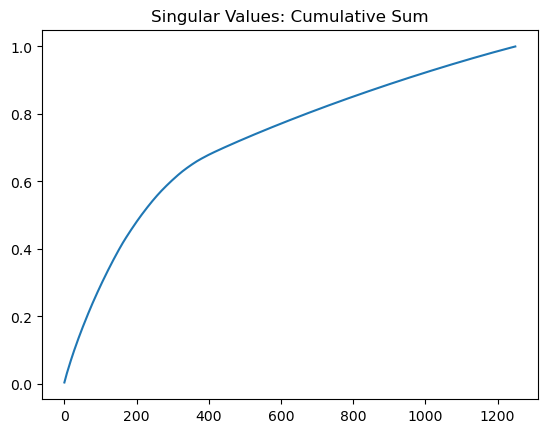

5%: 14 10%: 29 15%: 46 20%: 64 25%: 84 30%: 106 35%: 129 40%: 154 45%: 182 50%: 215 55%: 252 60%: 297 65%: 354 70%: 443 75%: 552 80%: 670 85%: 798 90%: 935 95%: 1084 100%: 1250 

In [10]:
plotCumSum(problemSetup.fullSVD.S)
for e in range(5, 101, 5):
    ranks = ranksForEnergyCapture(problemSetup.fullSVD.S, e/100.0)
    print(f'{e}%: {ranks} ', end = '')

In [ ]:
import csv, os

def txt_to_numpy(filename, row, sampleRate = 1.0):
    file = open(filename)
    lines = file.readlines()
    #skip = int(len(lines) * sampleRate)
    datamat = np.arange(row, dtype=float)
    row_count = 0
    for i in range(0, len(lines), int(sampleRate)):
        line = lines[i]
        line = line.strip().split(' ')
        datamat[row_count] = line[0]
        row_count += 1

    return datamat

def loadCSV(csvf):
    """
    return a dict saving the information of csv
    :param splitFile: csv file name
    :return: {label:[file1, file2 ...]}
    """
    dictLabels = {}
    with open(csvf) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        next(csvreader, None)  # skip (filename, label)
        for i, row in enumerate(csvreader):
            filename = row[0]
            label = row[1]

            # append filename to current label
            if label in dictLabels.keys():
                dictLabels[label].append(filename)
            else:
                dictLabels[label] = [filename]
    return dictLabels

csvdata_all = loadCSV(os.path.join(r'C:\Users\jodge\Documents\School\Summer24\tinymlcontest2022_demo_example\data_indices', 'train_indice.csv'))

names_list = []
for i, (k, v) in enumerate(csvdata_all.items()):
    names_list.append(str(k) + ' ' + str(v[0]))

print(names_list[:5])

def getitem(idx):
        text_path = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\tinyml_contest_data_training', names_list[idx].split(' ')[0])
        print(names_list[idx])
        if not os.path.isfile(text_path):
            print(text_path + ' does not exist')
            return None

        IEGM_seg = txt_to_numpy(text_path, 1250, 1.0).reshape(1, 1250, 1)
        label = int(names_list[idx].split(' ')[1])
        sample = {'IEGM_seg': IEGM_seg, 'label': label}

        return sample

for i in range(1):
    temp = getitem(i)
    print(temp)

In [14]:
from tqdm import tqdm

problemSetupsDir = r'C:\Users\jodge\Documents\School\Summer24\playground\data'
problemSetup = readObj(os.path.join(problemSetupsDir, 'full.pkl'))
print(problemSetup.r, problemSetup.p)
    
for fi in tqdm(directory_files): #special iterator that makes a progress bar
    temp = readFile(fi)
    mse, recon = measureAndReconstruct(problemSetup, temp)
    trunc = problemSetup.C @ temp
    #print(fi, type(recon), recon[:5])
    outReconName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\recon_data', 'R' + fi)
    outTruncName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\trunc_data', 'T' + fi)
    np.savetxt(outReconName, recon, fmt='%.7f')
    np.savetxt(outTruncName, trunc, fmt='%.7f')

print("DONE")

reading from C:\Users\jodge\Documents\School\Summer24\playground\data\full.pkl
106 107


100%|████████████████████████████████████████████████████████████████████████████| 30213/30213 [06:20<00:00, 79.49it/s]

DONE


In [ ]:
print(len(readFile(os.path.join(r'C:\Users\jodge\Documents\School\Summer24\trunc_data', 'T' + directory_files[1]))))

NameError: name 'directory_files' is not defined